In [29]:
pip install scikit-fuzzy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.1 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Define path to dataset
data_dir = "/kaggle/input/indian-food-classification/Food Classification"

In [4]:
# Define image size and batch size
image_size = (160, 160)  # Increase to 160x160 for better feature learning
batch_size = 32

In [5]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,  # 80-20 split for training and validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [6]:
# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 5024 images belonging to 20 classes.
Found 1245 images belonging to 20 classes.


In [7]:
import kagglehub

# Download latest version
path = kagglehub.model_download("hjhgkyo/h5/pyTorch/default")

print("Path to model files:", path)

Path to model files: /kaggle/input/h5/pytorch/default/1


In [8]:
from tensorflow.keras.applications import MobileNetV2

# weights file
weights_path = '/kaggle/input/h5/pytorch/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'

base_model = MobileNetV2(weights=weights_path, include_top=False, input_shape=(160, 160, 3))

In [9]:
# Freeze the base model to retain pre-trained weights during initial training
base_model.trainable = False

In [10]:
# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [11]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Initial training with frozen base model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732030089.837240     112 service.cc:145] XLA service 0x78dd00003e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732030089.837302     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/157 ━━━━━━━━━━━━━━━━━━━━ 52:08 20s/step - accuracy: 0.0625 - loss: 3.8586

I0000 00:00:1732030096.359672     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.3378 - loss: 2.3649 - val_accuracy: 0.8088 - val_loss: 0.7581
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 870ms/step - accuracy: 0.6201 - loss: 1.2432 - val_accuracy: 0.8369 - val_loss: 0.6177
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 872ms/step - accuracy: 0.6703 - loss: 1.1213 - val_accuracy: 0.8394 - val_loss: 0.5342
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 868ms/step - accuracy: 0.6883 - loss: 1.0193 - val_accuracy: 0.8474 - val_loss: 0.5209
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 862ms/step - accuracy: 0.7323 - loss: 0.8812 - val_accuracy: 0.8578 - val_loss: 0.4827
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 840ms/step - accuracy: 0.7327 - loss: 0.8937 - val_accuracy: 0.8418 - val_loss: 0.5081
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 878ms/step - accuracy: 0.7519 - loss: 0.8268 - val_accuracy: 0.8635 - val_loss: 0.4499
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 857ms/step - accuracy: 0.7486 - loss: 0.8013 

In [14]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 790ms/step - accuracy: 0.8743 - loss: 0.4176
Validation Loss: 0.44180887937545776
Validation Accuracy: 0.8634538054466248


In [15]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

In [16]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 157s 870ms/step - accuracy: 0.5976 - loss: 1.3737 - val_accuracy: 0.8763 - val_loss: 0.4245
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 851ms/step - accuracy: 0.6842 - loss: 1.0577 - val_accuracy: 0.8643 - val_loss: 0.4393
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 839ms/step - accuracy: 0.7173 - loss: 0.9287 - val_accuracy: 0.8739 - val_loss: 0.4238
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 877ms/step - accuracy: 0.7191 - loss: 0.9287 - val_accuracy: 0.8811 - val_loss: 0.4017
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 877ms/step - accuracy: 0.7440 - loss: 0.8468 - val_accuracy: 0.8827 - val_loss: 0.4027
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 882ms/step - accuracy: 0.7533 - loss: 0.8265 - val_accuracy: 0.8819 - val_loss: 0.3768
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 146s 896ms/step - accuracy: 0.7638 - loss: 0.7612 - val_accuracy: 0.8811 - val_loss: 0.3884
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 876ms/step - accuracy: 0.7711 -

In [18]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 813ms/step - accuracy: 0.8986 - loss: 0.3526
Validation Loss: 0.3771671652793884
Validation Accuracy: 0.8899598121643066


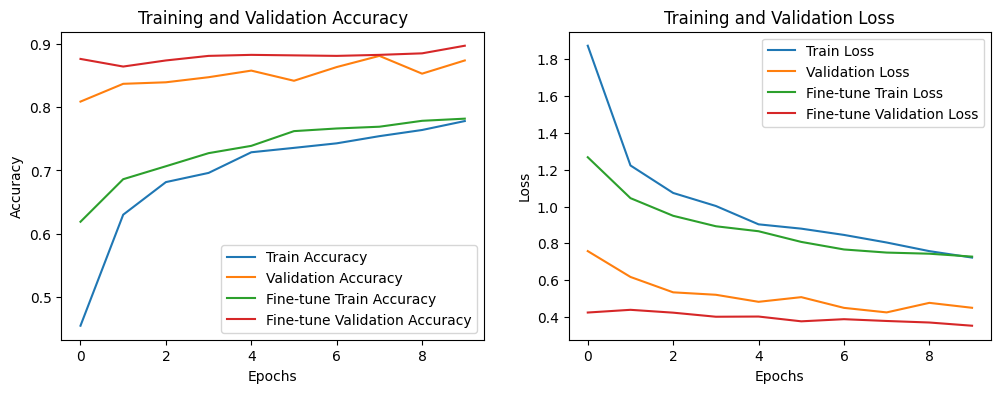

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-tune Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(fine_tune_history.history['loss'], label='Fine-tune Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-tune Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [20]:
import kagglehub

path = kagglehub.dataset_download("hjhgkyo/kqaaaaat")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kqaaaaat


In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

def prepare_image(img_path, target_size=(160, 160)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  # Normalize
    return img_array

img_path = '/kaggle/input/kqaaaaat/kat.jpg'

img = prepare_image(img_path)

predictions = model.predict(img)
predicted_class = np.argmax(predictions) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class Index: 10


In [22]:

predictions = model.predict(img)
predicted_class_index = np.argmax(predictions)  # Index of the highest probability class

class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Reverse the dictionary to map index to label

predicted_class_name = class_labels[predicted_class_index]
print(f"Predicted Food Class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Food Class: kaathi_rolls


In [23]:
# Save the model
model_save_path = '/kaggle/working/food_classification_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/food_classification_model.h5


In [25]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/kaggle/working/food_classification_model.h5')

In [26]:
import kagglehub

path = kagglehub.dataset_download("hjhgkyo/doasssa3")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/doasssa3


In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np


def prepare_image(img_path, target_size=(160, 160)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0  # Normalize
    return img_array

img_path = '/kaggle/input/doasssa3/dosa3.jpeg'
img = prepare_image(img_path)
predictions = loaded_model.predict(img)
predicted_class = np.argmax(predictions)  # Index of the highest probability class
print(f"Predicted Class Index: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class Index: 9


In [30]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

prob1 = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'prob1')
prob2 = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'prob2')
confidence = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'confidence')

# Membership function
prob1['low'] = fuzz.trimf(prob1.universe, [0, 0, 0.5])
prob1['medium'] = fuzz.trimf(prob1.universe, [0.2, 0.5, 0.8])
prob1['high'] = fuzz.trimf(prob1.universe, [0.5, 1, 1])

prob2['low'] = fuzz.trimf(prob2.universe, [0, 0, 0.5])
prob2['medium'] = fuzz.trimf(prob2.universe, [0.2, 0.5, 0.8])
prob2['high'] = fuzz.trimf(prob2.universe, [0.5, 1, 1])

confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.2, 0.5, 0.8])
confidence['high'] = fuzz.trimf(confidence.universe, [0.5, 1, 1])

#fuzzy rules
rule1 = ctrl.Rule(prob1['high'] & prob2['low'], confidence['high'])
rule2 = ctrl.Rule(prob1['medium'] & prob2['medium'], confidence['medium'])
rule3 = ctrl.Rule(prob1['low'] & prob2['high'], confidence['low'])

confidence_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
confidence_sim = ctrl.ControlSystemSimulation(confidence_ctrl)

# Modify prediction function
def fuzzy_predict(predictions):
    top_2_indices = np.argsort(predictions[0])[-2:]  # Get indices of top 2 predictions
    top_2_probs = predictions[0][top_2_indices]

    confidence_sim.input['prob1'] = top_2_probs[0]
    confidence_sim.input['prob2'] = top_2_probs[1]
    confidence_sim.compute()

    # confidence score
    fuzzy_confidence = confidence_sim.output['confidence']

    # final
    if fuzzy_confidence > 0.7:  
        return top_2_indices[0]  
    elif fuzzy_confidence > 0.4:  
        return f"Ambiguous: {top_2_indices}"  
    else:
        return top_2_indices[1]  

predictions = loaded_model.predict(img)
result = fuzzy_predict(predictions)
print(f"Fuzzy Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Fuzzy Prediction: 9
